# Recovery Forecasting Framework

To forecast recovery of call volumes after lockdown, we propose the following steps:

    (1) Identification of historical declines,
    (2) Analysis of historical declines and recoveries,
    (3) Scenario building,
    (4) Call volume time series decomposition,
    (5) Infusion of scenarios to call volume time series,
    (6) Combination of call volume time series components and scenarios, and
    (7) Forecasting call volume recovery

The steps are detailed below including a hypothetical call volume recovery forecast.

## (0) Loading packages to facilitate the analysis

The code below loaded the software packages that were be used.

In [1]:
installOrLoadPackage <- function(listOfPackages) {
    repository <- 'https://cloud.r-project.org/'
    for (package in listOfPackages) {
        if (package %in% row.names(installed.packages()) == TRUE) {
            update.packages(package, dependecies = TRUE, repos=repository)
        } else {
            install.packages(package, repos=repository)
        }
        require(package, character.only = TRUE)
    }
}
installOrLoadPackage(c('httr','XML','tidyquant','forecast','repr'))

Loading required package: httr

Warning message:
"package 'httr' was built under R version 3.5.3"
Loading required package: XML

Warning message:
"package 'XML' was built under R version 3.5.3"
Loading required package: tidyquant

Warning message:
"package 'tidyquant' was built under R version 3.5.3"
Loading required package: lubridate

Warning message:
"package 'lubridate' was built under R version 3.5.3"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: PerformanceAnalytics

Warning message:
"package 'PerformanceAnalytics' was built under R version 3.5.3"
Loading required package: xts

Warning message:
"package 'xts' was built under R version 3.5.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 3.5.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'Perfor

## (1) Identification of historical declines

To identify historical declines, we used S&P 500 data. S&P 500 data is publicly available and easy to obtain from Yahoo! Finance. It also contains several observations of historical recessions for the entire 20th century. It can be separated by industry through the Global Industry Classification Standard (GICS), and can be used to analyze historical declines and recoveries per industry. It is also reported daily.

With the use of S&P 500 data, we assumed that it is a proxy indicator for consumption which in turn generates call volumes. The S&P 500 prices are indications of investor confidence in the companies included in the portfolio. Investor confidence is a reaction to, among others, consumption of products and services of the 500 biggest US companies by market capitalization. For purposes of identifying and analyzing historical declines and recoveries, the S&P 500 is not a direct measurement of consumption, but it is a good enough proxy.

With the choice of S&P 500, we also limited this demonstration to hypothetical call volumes of a US account. A similar analysis can be performed on non-US accounts by choosing a more appropriate index for those accounts to replace the S&P 500.

The code below extracted information from Wikipedia about the companies in the S&P 500. We only used S&P 500 data beginning 1995, because we assumed that the current decline would likely be more similar to recent declines. We also limited the scope to the airline industry, but the scope can be changed to one of the 127 other industries printed below.

In [2]:
## Get S&P 500 constituents from Wikipedia ##
url <- 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
doc <- GET(url)
doc <- readHTMLTable(doc=content(doc, "text"))
doc <- doc$constituents
doc[,colnames(doc)] <- lapply(doc[,colnames(doc)], FUN=as.character)
doc_col_names <- as.character(doc[1,])
doc_col_names <- gsub(pattern='[^A-Za-z0-9]', replacement='_', doc_col_names)
doc_col_names <- gsub(pattern='_{2,}', replacement='_', doc_col_names)
doc_col_names <- gsub(pattern='^_{1,}|_{1,}$', replacement='', doc_col_names)
doc_col_names <- tolower(doc_col_names)
colnames(doc) <- doc_col_names
doc <- doc[-1,]
gicsSubIndustryList <- tolower(unique(doc$gics_sub_industry))
gicsSubIndustryList <- gicsSubIndustryList[order(gicsSubIndustryList)]
print(gicsSubIndustryList)

## Set-up start date and symbols ##
startDateTxt <- '1995-01-01'
gicsSubIndustry <- 'airlines'
startDate <- as.Date(startDateTxt)
startYear <- as.numeric(format(startDate, '%Y'))
startMonth <- as.numeric(format(startDate, '%m'))
symbol <- doc$symbol[tolower(doc$gics_sub_industry) == gicsSubIndustry]

  [1] "advertising"                                 
  [2] "aerospace & defense"                         
  [3] "agricultural & farm machinery"               
  [4] "agricultural products"                       
  [5] "air freight & logistics"                     
  [6] "airlines"                                    
  [7] "alternative carriers"                        
  [8] "apparel retail"                              
  [9] "apparel, accessories & luxury goods"         
 [10] "application software"                        
 [11] "asset management & custody banks"            
 [12] "auto parts & equipment"                      
 [13] "automobile manufacturers"                    
 [14] "automotive retail"                           
 [15] "biotechnology"                               
 [16] "brewers"                                     
 [17] "broadcasting"                                
 [18] "building products"                           
 [19] "cable & satellite"                     

The code below extracted the S&P 500 data for the companies GICS classified in the airline industry. The daily prices were summarized to monthly prices by weighted average. The monthly prices were displayed below, which captured the effect of the Global Financial Crisis of 2009, and the Covid-19 Pandemic this year.

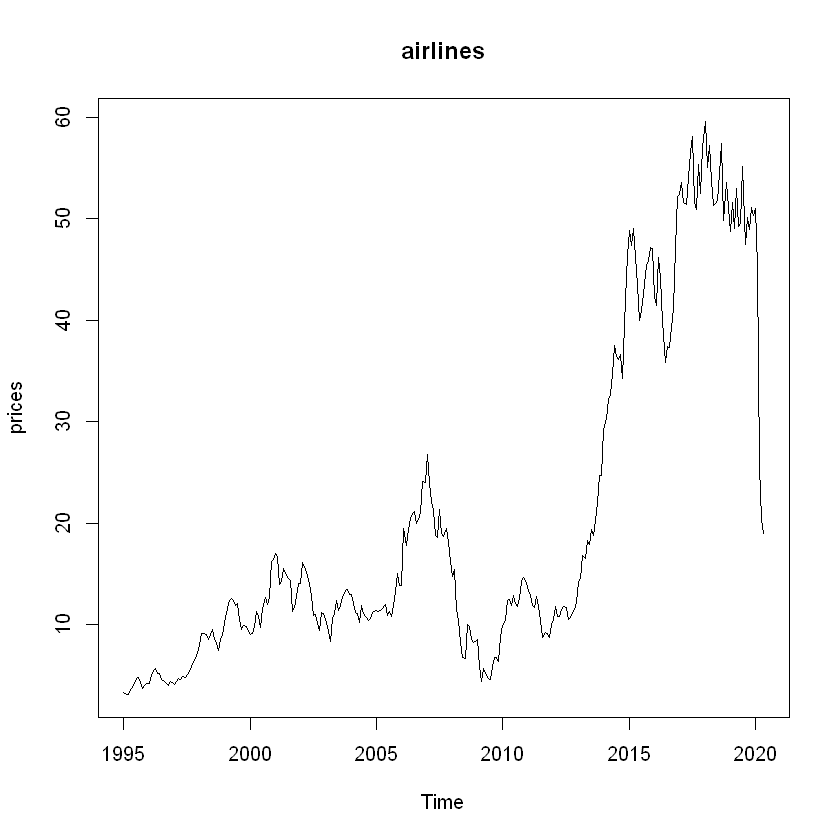

In [3]:
## Get S&P 500 prices ##
prices  <- tq_get(x = symbol, get = 'stock.prices', from = startDateTxt)
prices$sales <- prices$volume * prices$adjusted
prices$month <- format(prices$date, '%Y-%m')
volume <- aggregate(volume ~ month, data=prices, FUN=sum)
sales <- aggregate(sales ~ month, data=prices, FUN=sum)
prices <- merge(volume, sales, by='month', all=TRUE)
prices$price <- prices$sales/prices$volume
prices$volume <- prices$sales <- NULL
prices <- ts(prices$price[order(prices$month)], frequency=12, start=c(startYear, startMonth))
prices_df <- data.frame(date=as.Date(prices), price=as.numeric(prices))
prices_df$delta <- c(NA, diff(prices_df$price, lag=1))
plot(prices, main=gicsSubIndustry)

Recession is defined as two successive quarters of decreasing GDP. We similarly defined declines as five out of six consecutive months of decreasing S&P 500 prices, because the probability of 5 or more months of decreasing prices out of six consecutive months is less than 2%. Thus, five or more months of decreasing S&P 500 prices is anomalous. We used this definition of declines to identify them historically. The instances of declines found were displayed in a table below.

## (2) Analysis of historical declines and recoveries

In addition to when declines occurred, we were also interested in the duration of declines or when were the recoveries, how much the prices decreased from the start of the decline, and when did the prices reached the bottom before recoveries started.

We defined recoveries as the first instance the price is at least the price when the decline started. The time between the start of the decline and that first instance is the duration of the decline. There were instances that a decline overlapped with another decline. We kept both declines to have more samples.

We used the approximate percent difference of the price at the start of the decline, and the lowest price within the duration of the decline to define how much the prices decreased. We called this "severity". For example, if the price at the start of a decline was 100, and the lowest price within the decline is 75, the approximate percent difference is log(75 + 1) - log(100 + 1) or -28.44%. We used the approximate percent difference rather than the actual percent difference because approximate percent differences have less deviation than actual percent differences.

Finally, we took note of the month when the lowest price within the duration of the decline happened. We called this duration between the start of the decline and the month with the lowest price "half".

For example if the first row of the table below were:

         start half duration   severity        end     bottom
    1996-04-01    6       17 -0.2771324 1997-09-01 1996-10-01

This means that the start of the decline was on Apr 1996, and ended on Sep 1997. This decline lasted for 17 months (i.e. "duration"), and the price decreased by as much as 27.71% (i.e. "severity") at the sixth month (i.e. "half") or on Sep 1996.

We fitted Gaussian kernel density estimates to the severity samples, duration samples, and "half" samples. We displayed histograms and the fitted density estimates below. (The histogram of the "half" samples, and its fitted density estimate were labelled "Inflection".) The Gaussian kernel density estimates were used to build scenarios.

        start half duration   severity        end     bottom
1  1996-04-01    6       17 -0.2771324 1997-09-01 1996-10-01
2  1999-08-01    5        8 -0.1379238 2000-04-01 2000-01-01
3  2002-01-01   14       46 -0.4790472 2005-11-01 2003-03-01
4  2002-09-01    6        7 -0.1796259 2003-04-01 2003-03-01
5  2003-11-01    6       24 -0.2551894 2005-11-01 2004-05-01
6  2006-12-01   27       83 -1.5427305 2013-11-01 2009-03-01
7  2007-08-01   19       71 -1.3160595 2013-07-01 2009-03-01
8  2008-03-01   12       24 -0.8441544 2010-03-01 2009-03-01
9  2009-02-01    1        6 -0.2430985 2009-08-01 2009-03-01
10 2010-11-01    9       28 -0.4796132 2013-03-01 2011-08-01
11 2011-06-01    2       12 -0.2810825 2012-06-01 2011-08-01
12 2015-12-01    6       11 -0.2662688 2016-11-01 2016-06-01
13 2019-12-01   NA       NA         NA       <NA>       <NA>


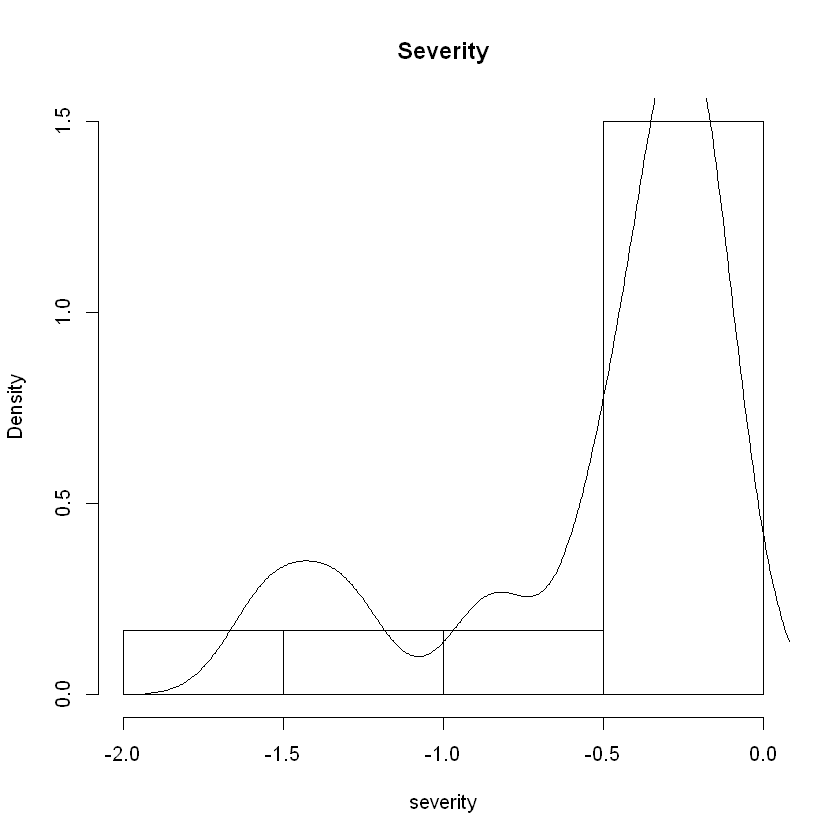

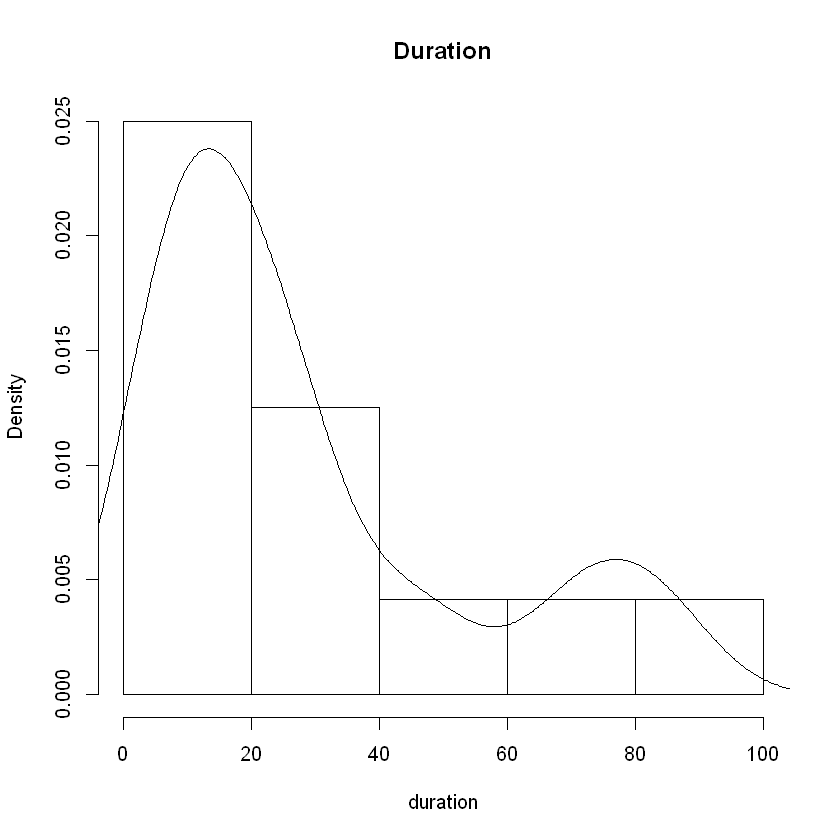

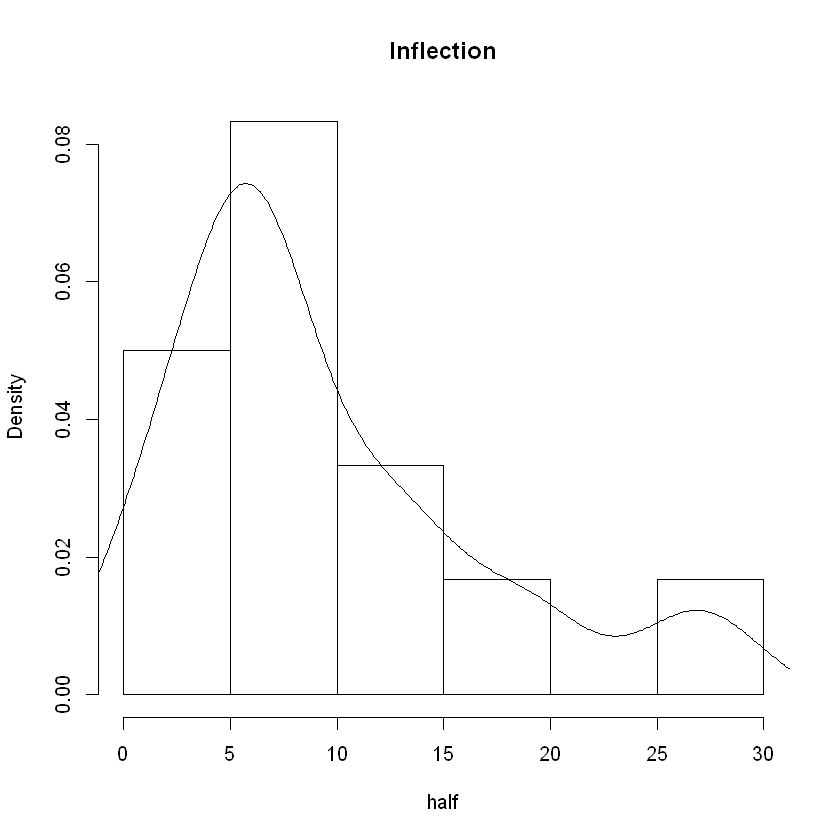

In [4]:
## Find historical declines, i.e. decreasing prices in atleast five of six consecutive months ##
starts <- c()
for (i in 1:nrow(prices_df)) {
    if (sum(prices_df$delta[i:min(i+5, nrow(prices_df))] < 0, na.rm=TRUE) >= 5) {
        if (!is.null(starts)) {
            if (i - starts[length(starts)] > 6) { starts <- unique(c(starts, i)) }
        } else { starts <- i }
    }
}
ends <- c()
for (i in starts) {
    candidate_idx <- which(prices_df$price[i] <= prices_df$price)
    candidate_idx <- candidate_idx[i + 5 < candidate_idx]
    if (length(candidate_idx) > 0) { ends <- c(ends, min(candidate_idx)) }
    else { ends <- c(ends, Inf) }
}
recession_intervals <- ends - starts
recession_intervals <- recession_intervals[-Inf < recession_intervals & recession_intervals < Inf]

inflxn_points <- c()
decreases <- c()
for (i in 1:length(starts)) {
    if (-Inf < starts[i] & ends[i] < Inf){
        j <- which.min(prices_df$price[starts[i]:ends[i]])
        inflxn_points <- c(inflxn_points, starts[i] + j - 1)
        decreases <- c(decreases, log1p(min(prices_df$price[starts[i]:ends[i]])) - log1p(prices_df$price[starts[i]]))
    } else if (starts[i] <= -Inf) {
        inflxn_points <- c(inflxn_points, -Inf)
    } else {
        inflxn_points <- c(inflxn_points,  Inf)
    }
}
inflection_intervals <- inflxn_points - starts
inflection_intervals <- inflection_intervals[-Inf < inflection_intervals & inflection_intervals < Inf]

recessions <- data.frame(start=prices_df$date[starts])
recessions$bottom <- recessions$end <- recessions$severity <- recessions$severity <- recessions$duration <- recessions$half <- NA
recessions$bottom <- prices_df$date[inflxn_points]
recessions$end <- prices_df$date[ends]
recessions$severity[1:length(decreases)] <- decreases
recessions$duration[1:length(recession_intervals)] <- recession_intervals
recessions$half[1:length(inflection_intervals)] <- inflection_intervals

print(recessions)

severity <- recessions$severity[!is.na(recessions$severity)]
severity_kde <- density(severity, na.rm=TRUE)
hist(severity, prob=TRUE, main='Severity')
lines(severity_kde)

duration <- recessions$duration[!is.na(recessions$duration)]
duration_kde <- density(duration, na.rm=TRUE)
hist(duration, prob=TRUE, main='Duration')
lines(duration_kde)

half <- recessions$half[!is.na(recessions$half)]
half_kde <- density(half, na.rm=TRUE)
hist(half, prob=TRUE, main='Inflection')
lines(half_kde)

## (3) Scenario building

Severity, duration, and inflections of declines are random variables. There is no way to definitely know what values they will take when a decline starts. But if we we were to assume that future declines are similar to recent declines, historical declines can give us likely values. Suppose we have collected the characteristics of declines in the table below. 

                start half duration   severity        end     bottom
        1  1996-04-01    6       17 -0.2771324 1997-09-01 1996-10-01
        2  1999-08-01    5        8 -0.1379238 2000-04-01 2000-01-01
        3  2002-01-01   14       46 -0.4790472 2005-11-01 2003-03-01
        4  2002-09-01    6        7 -0.1796259 2003-04-01 2003-03-01
        5  2003-11-01    6       24 -0.2551894 2005-11-01 2004-05-01
        6  2006-12-01   27       83 -1.5427141 2013-11-01 2009-03-01
        7  2007-08-01   19       71 -1.3160514 2013-07-01 2009-03-01
        8  2008-03-01   12       24 -0.8441494 2010-03-01 2009-03-01
        9  2009-02-01    1        6 -0.2430979 2009-08-01 2009-03-01
        10 2010-11-01    9       28 -0.4796183 2013-03-01 2011-08-01
        11 2011-06-01    2       12 -0.2810831 2012-06-01 2011-08-01
        12 2015-12-01    6       11 -0.2662689 2016-11-01 2016-06-01

It can be seen that the duration of most declines tend to be short: half of historical declines lasted 20 months or less; 75% lasted 33 months or less. If the assumption holds that future declines are similar to recent declines, declines lasting 10 years (120 months) or more are possible but quite rare, while declines lasting 2 years (24 months) or less are more likely. Similarly, it can be also be seen that declines tend to be less severe, but severe declines are still possible but rare. Finally, it can be seen that declines are likely to start getting better within a year after they start, but slow recoveries are still possible though rare.

We used the kernel density estimates to draw random values of duration, severity, and inflection. We then combined those to construct 100 scenarios to build upon our recovery forecast. Displayed below are 5 of the 100 scenarios.

In [5]:
rdens <- function(n=n, density=density, data=data, kernel="gaussian") {
    width <- density$bw
    rkernel <- function(n) rnorm(n, sd=width)
    sample(data, n, replace=TRUE) + rkernel(n)
}

set.seed(67890)
scenarios <- data.frame(severity = rdens(n=1000, density=severity_kde, data=severity)
                       ,duration = rdens(n=1000, density=duration_kde, data=duration)
                       ,half     = rdens(n=1000, density=half_kde,     data=half))

scenarios$duration <- round(scenarios$duration,0)
scenarios$half <- round(scenarios$half,0)
scenarios <- scenarios[complete.cases(scenarios),]
scenarios <- scenarios[scenarios$severity <  0,]
scenarios <- scenarios[scenarios$duration >= 6,]
scenarios <- scenarios[1 <= scenarios$half & scenarios$half < scenarios$duration,]
scenarios <- scenarios[sample(1:nrow(scenarios), size=100, replace=FALSE),]
head(scenarios, 5)

,severity,duration,half
926,-0.4663761,67,3
578,-0.2087574,23,11
856,-1.2323815,28,11
921,-1.4674386,13,2
3,-0.4296252,28,13


## (3.5) Load a hypothetical three-year historical call volume data

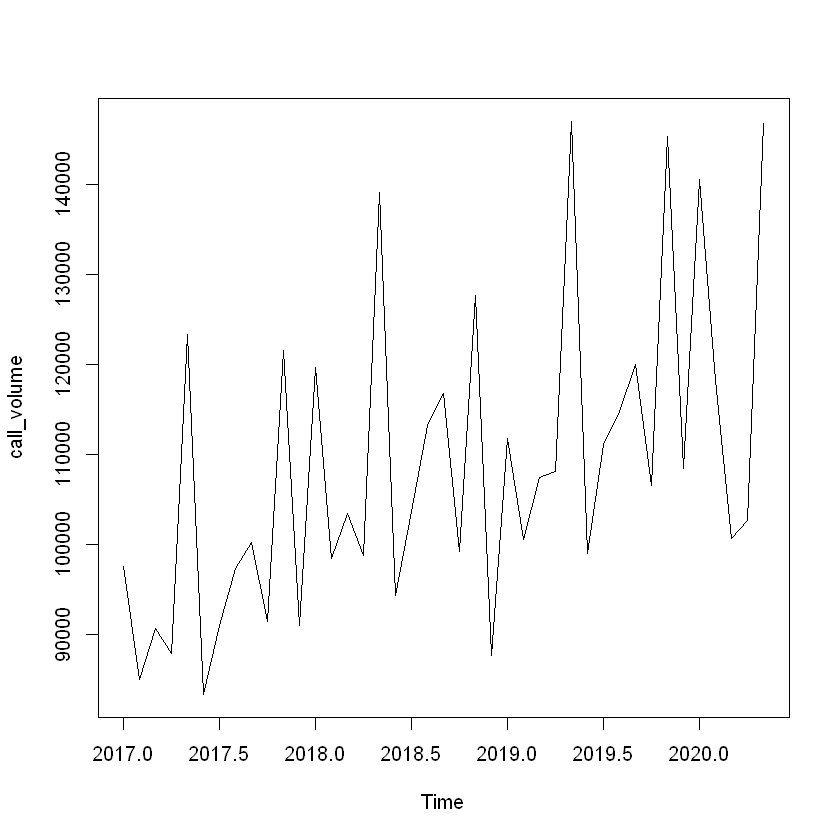

In [6]:
startDateTxt <- '2017-01-01'
startDate <- as.Date(startDateTxt)
startYear <- as.numeric(format(startDate, '%Y'))
startMonth <- as.numeric(format(startDate, '%m'))
symbol <- '^GSPC'
call_volume <- tq_get(x = symbol, get = 'stock.prices', from = startDateTxt)
call_volume$sales <- call_volume$volume * call_volume$adjusted
call_volume$month <- format(call_volume$date, '%Y-%m')
volume <- aggregate(volume ~ month, data=call_volume, FUN=sum)
sales <- aggregate(sales ~ month, data=call_volume, FUN=sum)
call_volume <- merge(volume, sales, by='month', all=TRUE)
call_volume$volume <- call_volume$sales/call_volume$volume
call_volume$sales <- NULL
set.seed(54321)
mltplr <- 100*runif(n=1)
seasonalC <- exp(runif(n=12, min=-0.25, max=0.25))
seasonalC <- as.numeric(rep(seasonalC, length.out=nrow(call_volume)))
call_volume$volume <- call_volume$volume * mltplr * seasonalC
call_volume$volume <- round(call_volume$volume,0)
call_volume <- ts(as.numeric(call_volume$volume), frequency=12, start=c(startYear, startMonth))
plot(call_volume)

## (4) Call volume time series decomposition

The monthly call volume would be transformed logarithmically to stabilize variances. They would then be decomposed to the following components, if they empirically exist:

    (1) Trends, which are combinations of level and growth (slope), and/or
    (2) Seasonalities (season)

Decomposition would enable the manipulation of trends to fit several scenarios generated above, then the reconstruction of the series to forecast call volumes into the future until declines have recovered.

ETS(A,Ad,A) 

Call:
 ets(y = call_volume + 1, lambda = 0) 

  Box-Cox transformation: lambda= 0 

  Smoothing parameters:
    alpha = 0.9994 
    beta  = 0.013 
    gamma = 1e-04 
    phi   = 0.9799 

  Initial states:
    l = 11.4028 
    b = 0.0177 
    s = -0.1541 0.1746 -0.1007 0.0309 0.0106 -0.0452
           -0.1257 0.2707 -0.0584 -0.0446 -0.0535 0.0953

  sigma:  0.0502

      AIC      AICc       BIC 
-79.02200 -47.93109 -48.17771 


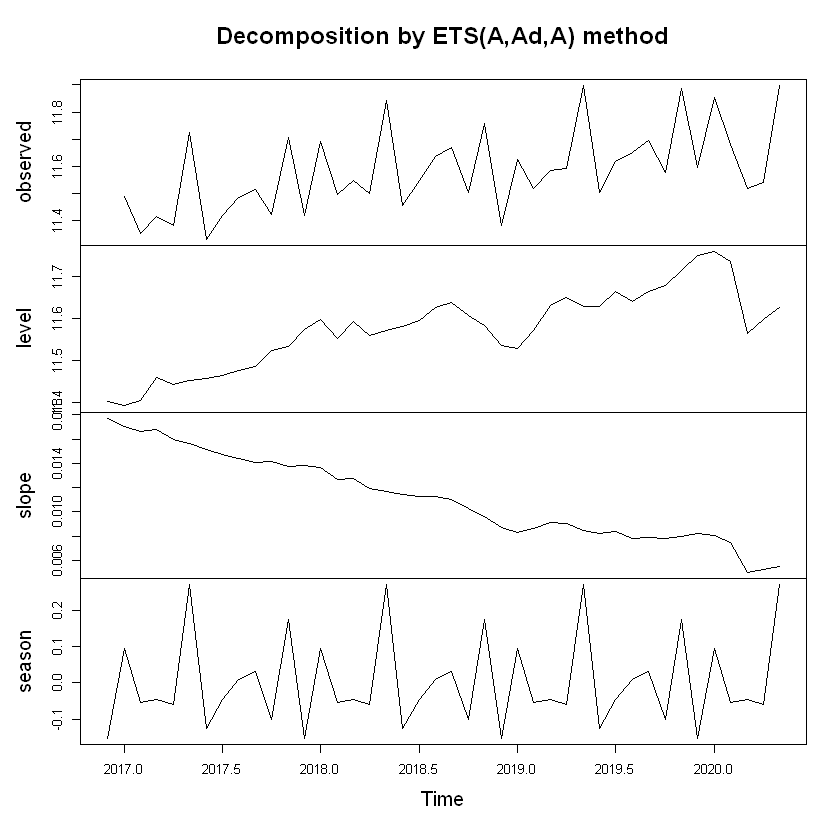

In [7]:
fit_ets <- ets(call_volume + 1, lambda = 0)
plot(fit_ets)
print(fit_ets)

## (5) Infusion of scenarios to call volume time series

Suppose we infused this scenario to the call volume time series:

      severity duration half
	-0.4663777       67    3

The decline lasted 67 months, and reached the bottom 3 months after the decline started. From the start of the decline to the bottom, the call volume decreased by 46.63777%.

The level would be infused with the scenario above. Plotting the level component of the call volume trend would make the location of the most recent decline easy to find. The most recent decline started at the time of the vertical red dashed line. The decline would end after 67 months (vertical green dashed line), and would reach the bottom of the decline after 3 months (vertical orange dashed line). It was then assumed that the blue dashed line would be future path of the level. 

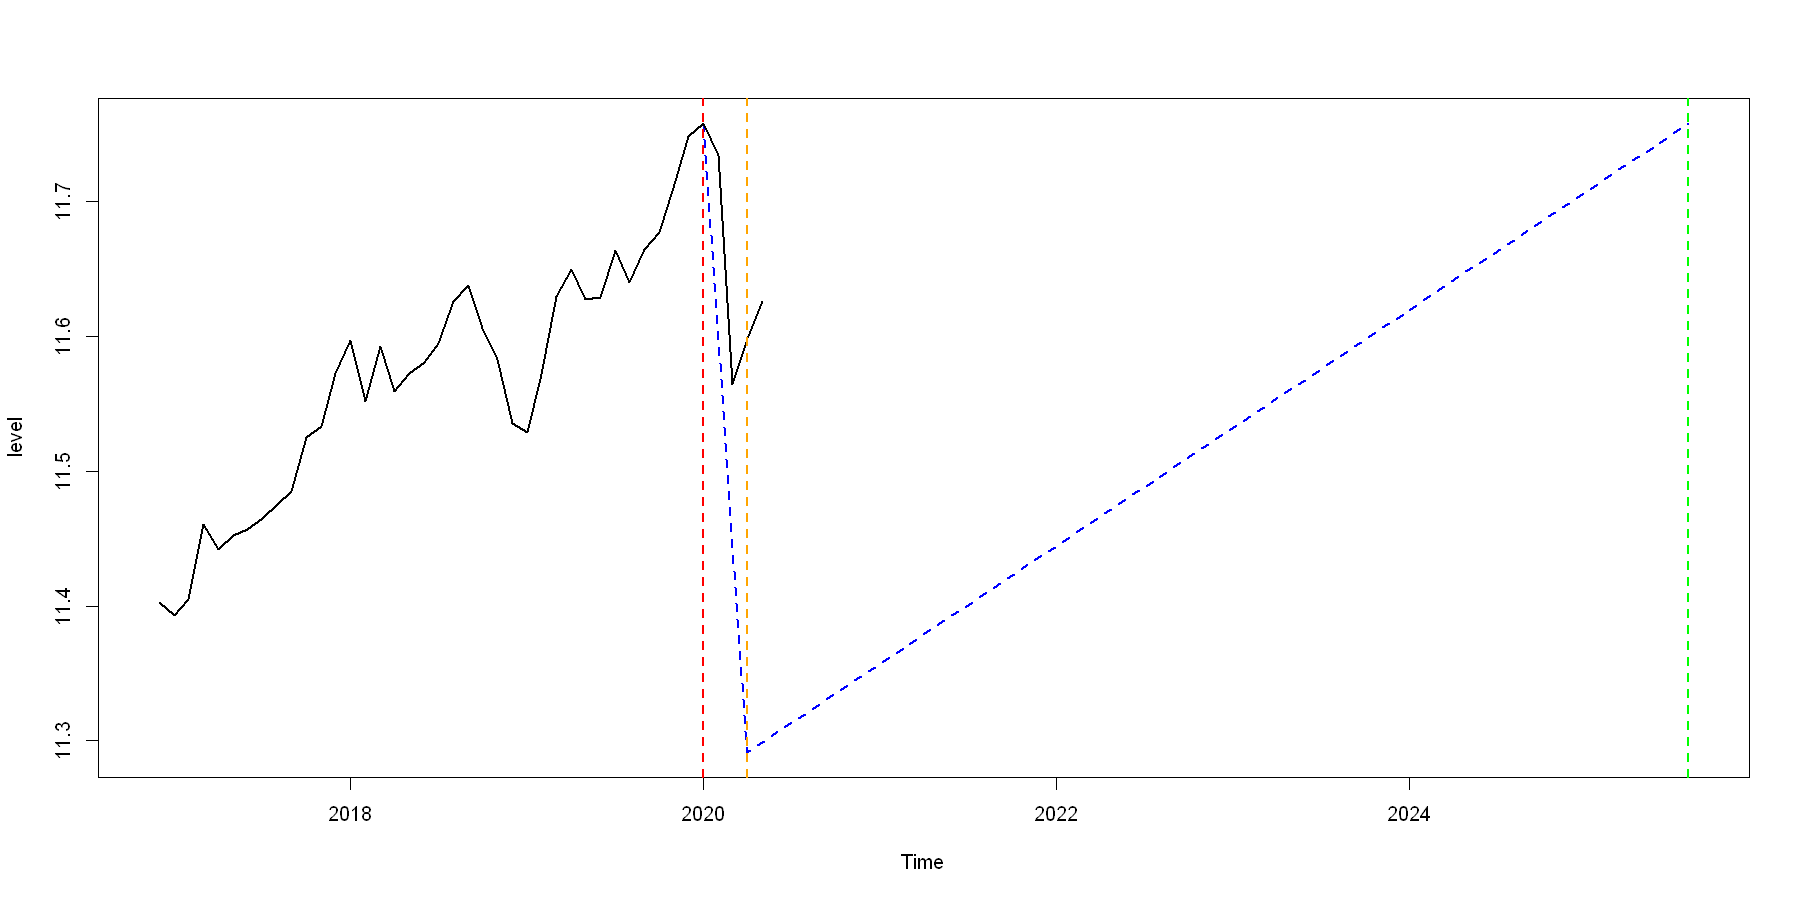

In [8]:
scenario <- list(severity = -0.4663777, duration = 67, half = 3)
model <- fit_ets

base_series <- data.frame(date=as.Date(model$states[,'l']), l=as.numeric(model$states[,'l']))
base_series$delta_l <- c(NA, diff(base_series$l, lag=1))

startDate <- max(base_series$date)
for (i in nrow(base_series):2) {
    if (base_series[i-1,3] > 0 & base_series[i,3] < 0) {
        startDate <- base_series[i-1,'date']
        break
    }
}

duration <- scenario$duration
severity <- scenario$severity
half <- scenario$half

startNumeric <- as.numeric(format(startDate, '%Y')) + (as.numeric(format(startDate, '%m'))-1)/12
endNumeric <- startNumeric + duration/12
halfNumeric <- startNumeric + half/12

dates <- seq(from=startDate, by='month', length.out=duration + 1)
dates <- dates[!dates %in% base_series$date]
dates <- dates[order(dates)]

future_states <- data.frame(date = dates)
future_states <- merge(base_series, future_states, by='date', all=TRUE)
future_states$delta_l <- NULL
startIdx <- which(future_states$date == startDate)

lowest_point <- severity + future_states$l[startIdx]
delta_dec <- (lowest_point - future_states$l[startIdx])/half
seq_dec <- seq(from=future_states$l[startIdx], by=delta_dec, length.out=half)

delta_inc <- (future_states$l[startIdx] - lowest_point)/(duration - half)
seq_inc <- seq(from=lowest_point, by=delta_inc, length.out=1 + duration - half)
future_states$l_hat <- NA
future_states$l_hat[startIdx:nrow(future_states)] <- c(seq_dec, seq_inc)

startYear <- as.numeric(format(min(future_states$date), '%Y'))
startMonth <- as.numeric(format(min(future_states$date), '%m'))

l_actuals <- ts(future_states$l, frequency = 12, start=c(startYear, startMonth))
l_fits <- ts(future_states$l_hat, frequency = 12, start=c(startYear, startMonth))

options(repr.plot.width=15, repr.plot.height=7.5)
plot(l_fits, lwd=2, lty=2, col='blue', ylab='level')
lines(l_actuals, lwd=2, lty=1, col='black')

abline(v=startNumeric, lty=2, lwd=2, col='red')
abline(v=endNumeric, lty=2, lwd=2, col='green')
abline(v=halfNumeric, lty=2, lwd=2, col='orange')

## (6) Combination of call volume time series components and scenarios

After a generated scenario was infused into the level component, by assuming that the growth (slope) and seasonal components remained  unchanged, the components would be projected into the future, as illustrated below. The level, growth, and seasonal components would then be combined to form a forecast of monthly call volumes based on a single scenario also illustrated below. The process would be repeated for 100 scenarios generated from the kernel density estimates of severity, duration, and inflection.

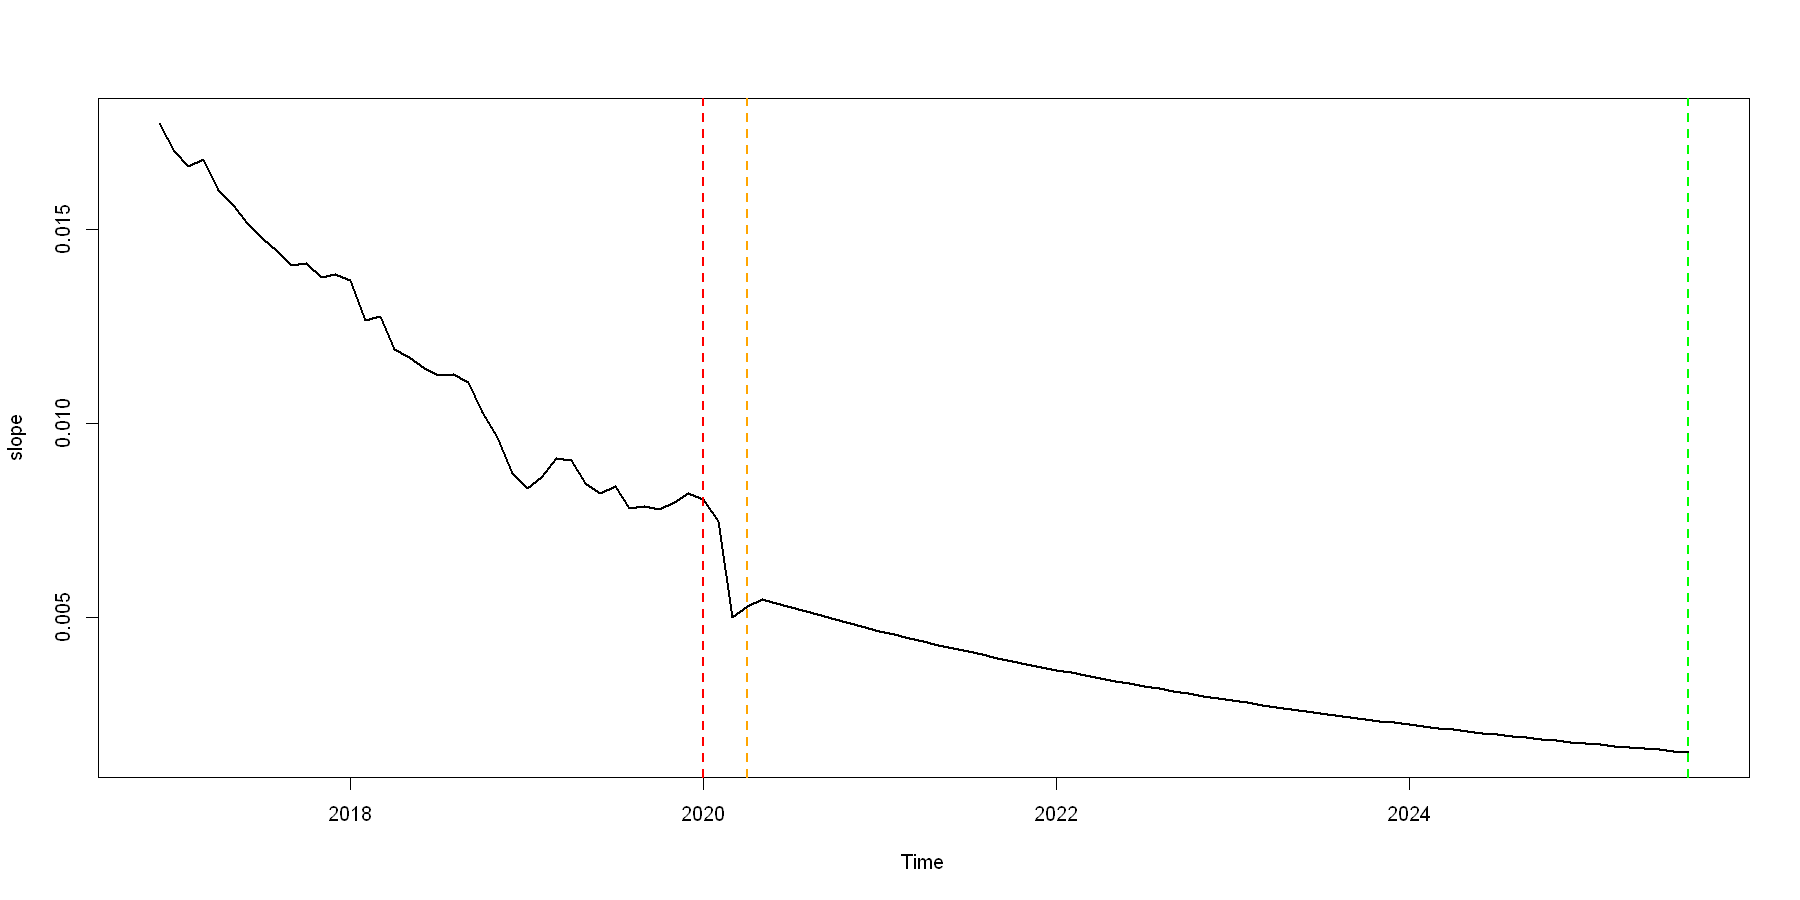

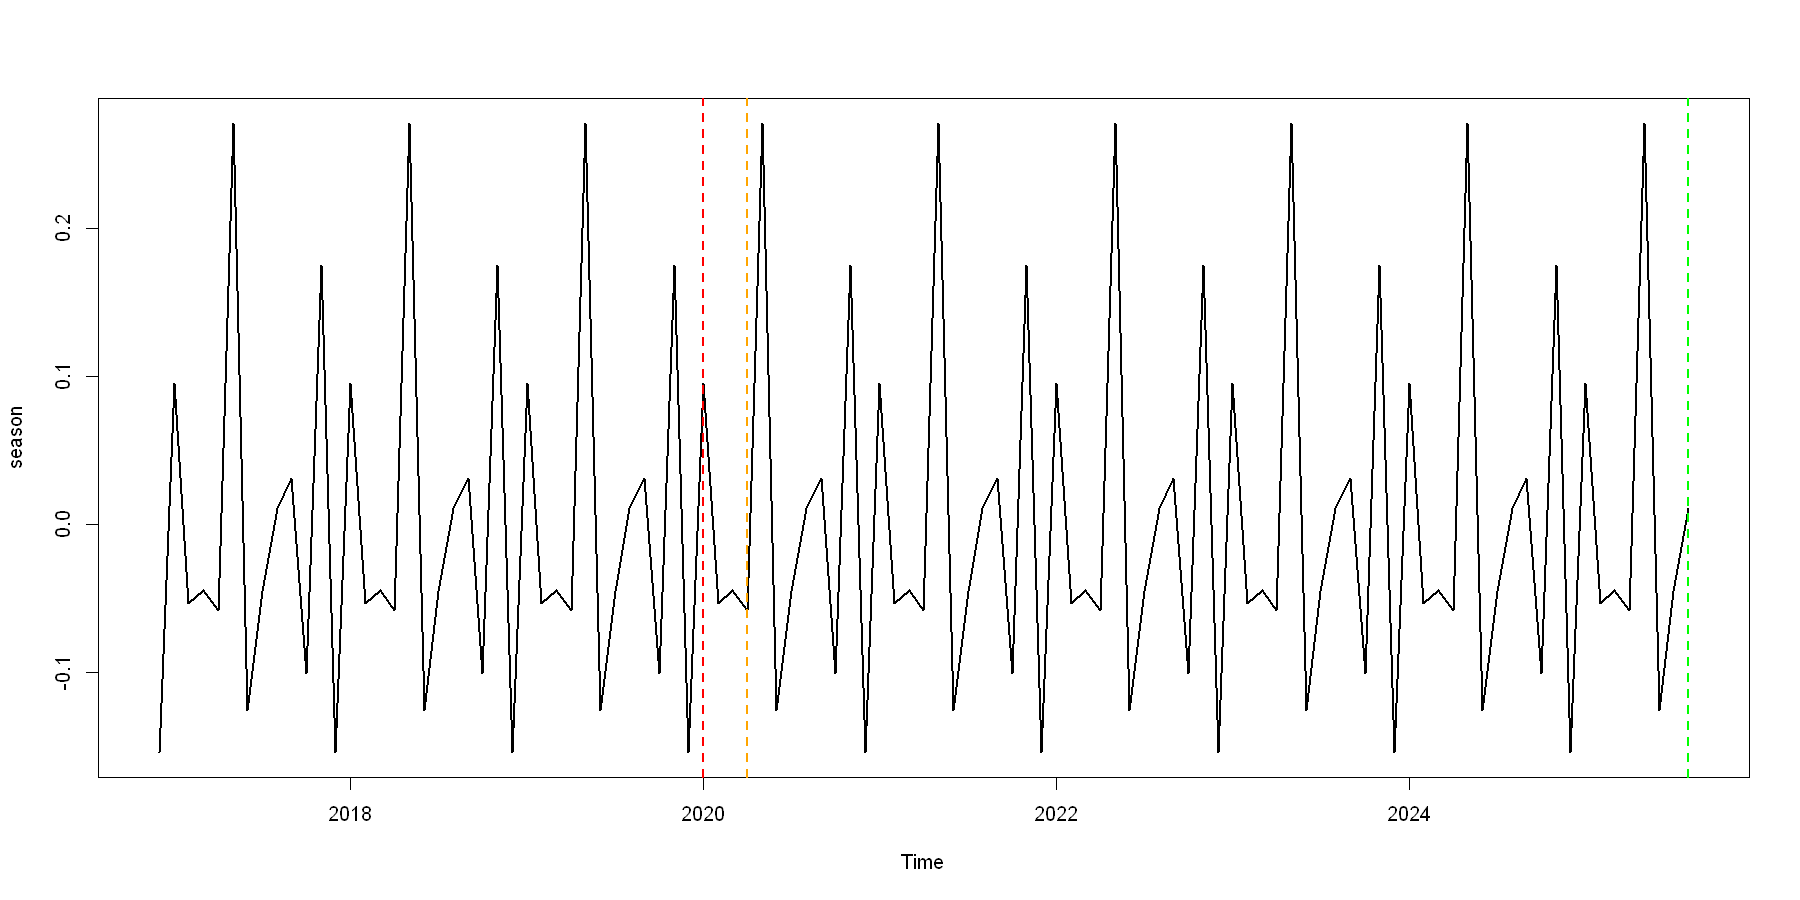

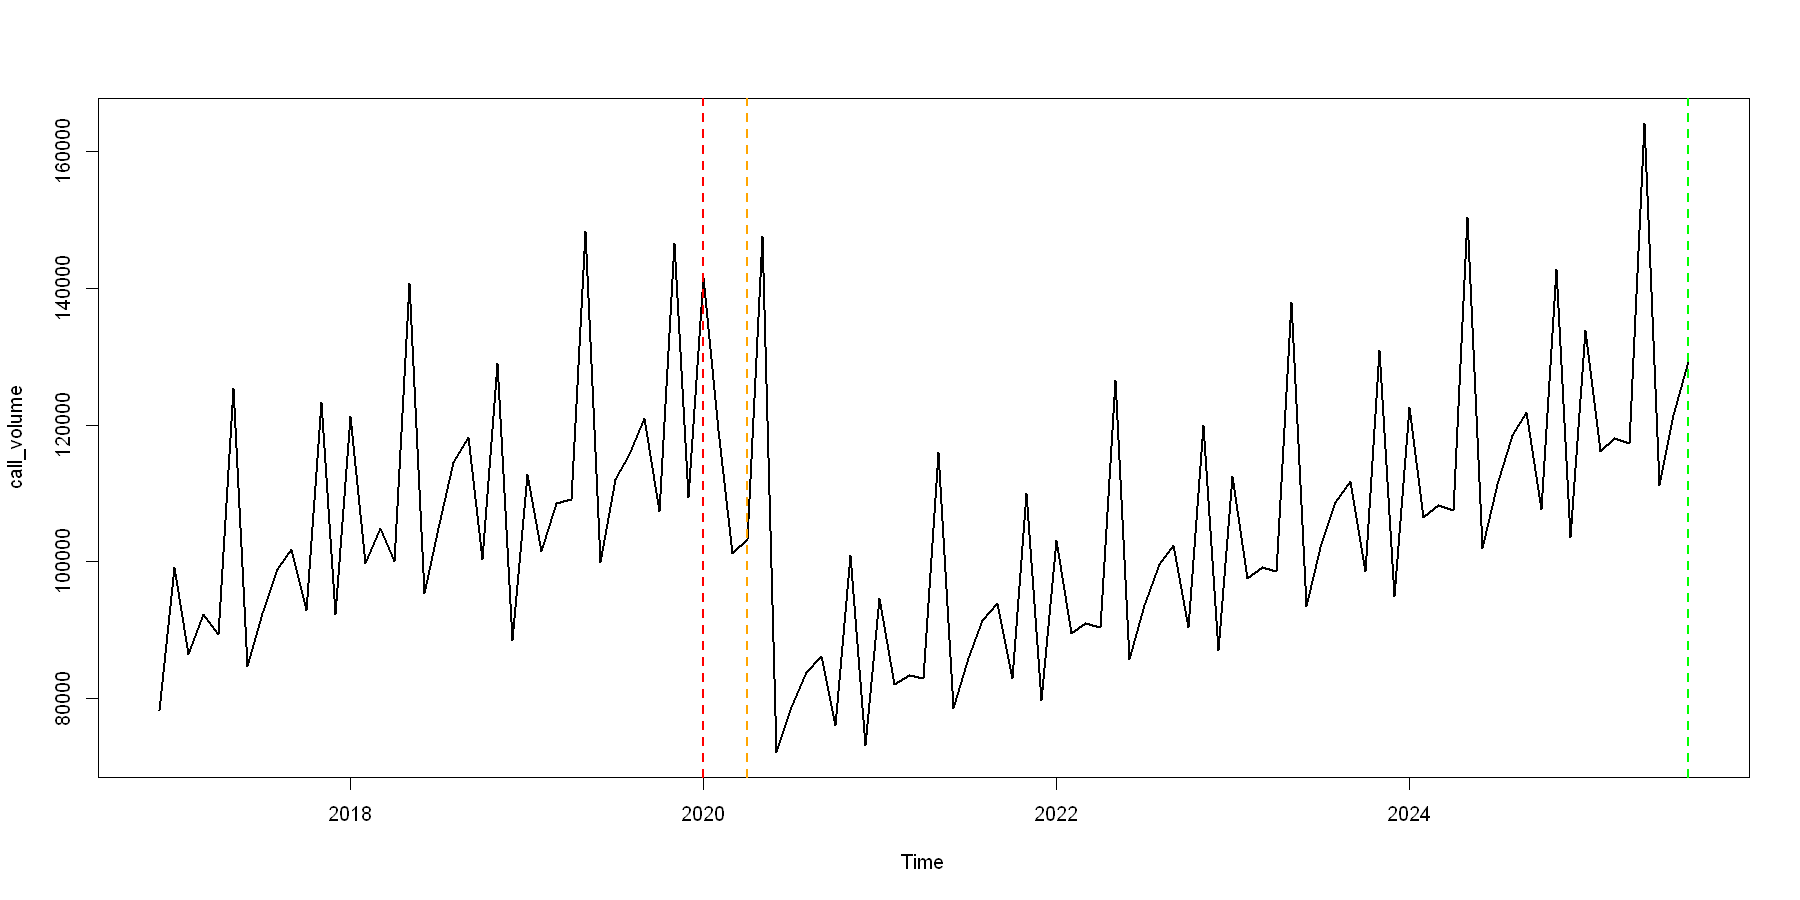

In [9]:
if (model$components[3] != 'N') { 
    future_states$s <- NA
    future_states$s[1:length(model$states[,'s1'])] <- model$states[,'s1']
    for (i in dates) {
        future_states$s[future_states$date == i] <- future_states$s[future_states$date == (as.Date(i) %m-% months(12))] 
    }
} else {
    future_states$s <- rep(x=0, times=nrow(future_states))
}

if (model$components[2] != 'N') {
    future_states$b <- NA
    future_states$b[1:length(model$states[,'b'])] <- model$states[,'b']
    if (model$components[4] == 'TRUE') { 
        phi <- model$par[['phi']]
    } else { phi <- 1 }
    for (i in dates) {
        future_states$b[future_states$date == i] <- phi * future_states$b[future_states$date == (as.Date(i) %m-% months(1))] 
    }
} else {
    future_states$b <- rep(x=0, times=nrow(future_states))
}

plot(ts(future_states$b, frequency = 12, start=c(startYear, startMonth)), lwd=2, lty=1, col='black', ylab='slope')
abline(v=startNumeric, lty=2, lwd=2, col='red')
abline(v=endNumeric, lty=2, lwd=2, col='green')
abline(v=halfNumeric, lty=2, lwd=2, col='orange')

plot(ts(future_states$s, frequency = 12, start=c(startYear, startMonth)), lwd=2, lty=1, col='black', ylab='season')
abline(v=startNumeric, lty=2, lwd=2, col='red')
abline(v=endNumeric, lty=2, lwd=2, col='green')
abline(v=halfNumeric, lty=2, lwd=2, col='orange')

future_states$fit <- expm1(ifelse(!is.na(future_states$l), future_states$l, future_states$l_hat) + 
                           future_states$b + future_states$s)

plot(ts(future_states$fit, frequency = 12, start=c(startYear, startMonth)), lwd=2, lty=1, col='black', ylab='call_volume')
abline(v=startNumeric, lty=2, lwd=2, col='red')
abline(v=endNumeric, lty=2, lwd=2, col='green')
abline(v=halfNumeric, lty=2, lwd=2, col='orange')

The function below creates a set of forecasts based on a specific scenario.

In [10]:
recovery_forecast <- function(scenario, model) {
    
    states_lts <- data.frame(date = as.Date(model$states[,'l']), l = as.numeric(model$states[,'l']))

    if (model$components[2] != 'N') {
        states_lts$b <- as.numeric(model$states[,'b' ])
    } else {
        states_lts$b <- rep(x=0, times=nrow(states_lts))
    }

    if (model$components[3] != 'N') { 
        states_lts$s <- as.numeric(model$states[,'s1']) 
    } else {
        states_lts$s <- rep(x=0, times=nrow(states_lts))
    }

    states_lts$delta_l <- c(NA, diff(states_lts$l, lag=1))
    states_lts$delta_b <- c(NA, diff(states_lts$b, lag=1))

    if (all(states_lts$delta_l > 0, na.rm=TRUE) | all(states_lts$delta_l < 0, na.rm=TRUE)) {
        monotone_l <- TRUE
    } else {
        monotone_l <- FALSE
    }

    if (all(states_lts$delta_b > 0, na.rm=TRUE) | all(states_lts$delta_b < 0, na.rm=TRUE)) {
        monotone_b <- TRUE
    } else {
        monotone_b <- FALSE
    }

    if (!monotone_l) {
        base_series <- states_lts[,c('date','l','delta_l')]
    } else if (monotone_l & !monotone_b) {
        base_series <- states_lts[,c('date','b','delta_b')]
    } else {
        base_series <- states_lts[,c('date','l','delta_l')]
    }

    startDate <- max(base_series$date)
    for (i in nrow(base_series):2) {
        if (base_series[i-1,3] > 0 & base_series[i,3] < 0) {
            startDate <- base_series[i-1,'date']
            break
        }
    }

    duration <- scenario$duration
    dates <- seq(from=startDate, by='month', length.out=1 + duration)
    dates <- dates[!dates %in% states_lts$date]
    dates <- dates[order(dates)]

    future_states <- data.frame(date = dates)
    future_states <- merge(states_lts, future_states, by=intersect(names(states_lts), names(future_states)), all=TRUE)
    future_states$delta_l <- future_states$delta_b <- NULL

    if (model$components[3] != 'N') {
        for (i in dates) {
            future_states$s[future_states$date == i] <- future_states$s[future_states$date == (as.Date(i) %m-% months(12))] 
        }
    } else {
        future_states$s <- rep(x=0, times=nrow(future_states))
    }

    if (model$components[2] != 'N') {
        if (model$components[4] == 'TRUE') { 
            phi <- model$par[['phi']]
        } else { phi <- 1 }
        for (i in dates) {
            future_states$b[future_states$date == i] <- phi * future_states$b[future_states$date == (as.Date(i) %m-% months(1))] 
        }
    } else {
        future_states$b <- rep(x=0, times=nrow(future_states))
    }

    severity <- scenario$severity
    half <- scenario$half
    startIdx <- which(future_states$date == startDate)
    
    lowest_point <- severity + future_states$l[startIdx]
    delta_dec <- (lowest_point - future_states$l[startIdx])/half
    seq_dec <- seq(from=future_states$l[startIdx], by=delta_dec, length.out=half)
    delta_inc <- (future_states$l[startIdx] - lowest_point)/(duration - half)
    seq_inc <- seq(from=lowest_point, by=delta_inc, length.out=1 + duration - half)
    future_states$l_hat <- NA
    future_states$l_hat[startIdx:nrow(future_states)] <- c(seq_dec, seq_inc)
    future_states$l[is.na(future_states$l)] <- future_states$l_hat[is.na(future_states$l)]
    future_states$l_hat <- NULL

    future_states$fit <- future_states$l + future_states$b + future_states$s

    return(future_states)

}

Below are four other sets of forecasts based on the same historical data but on four different scenarios.

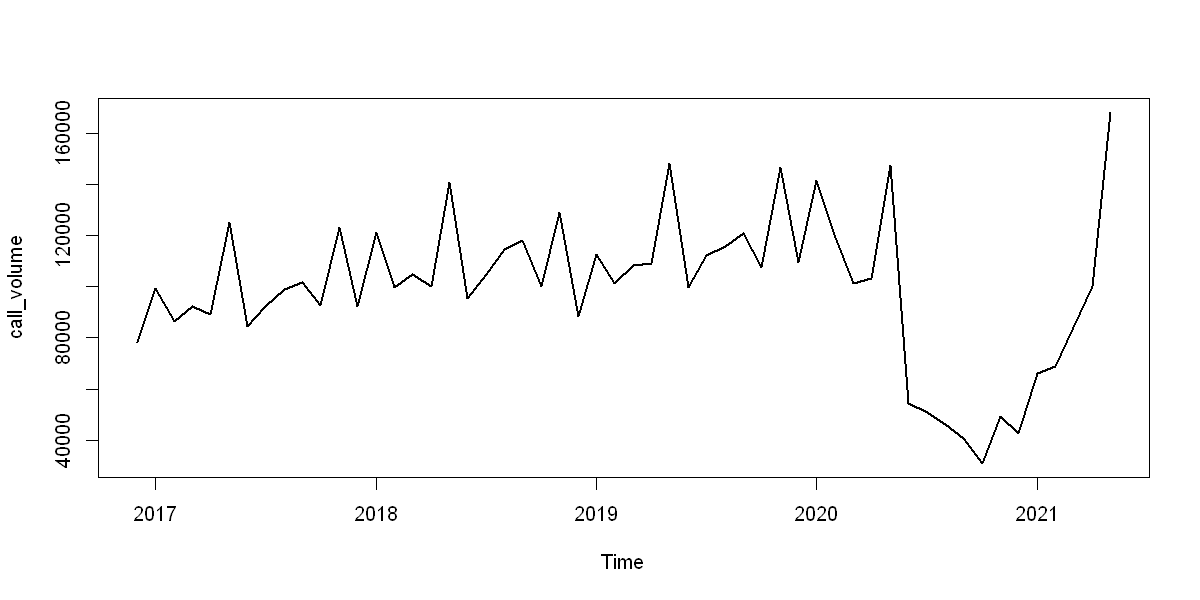

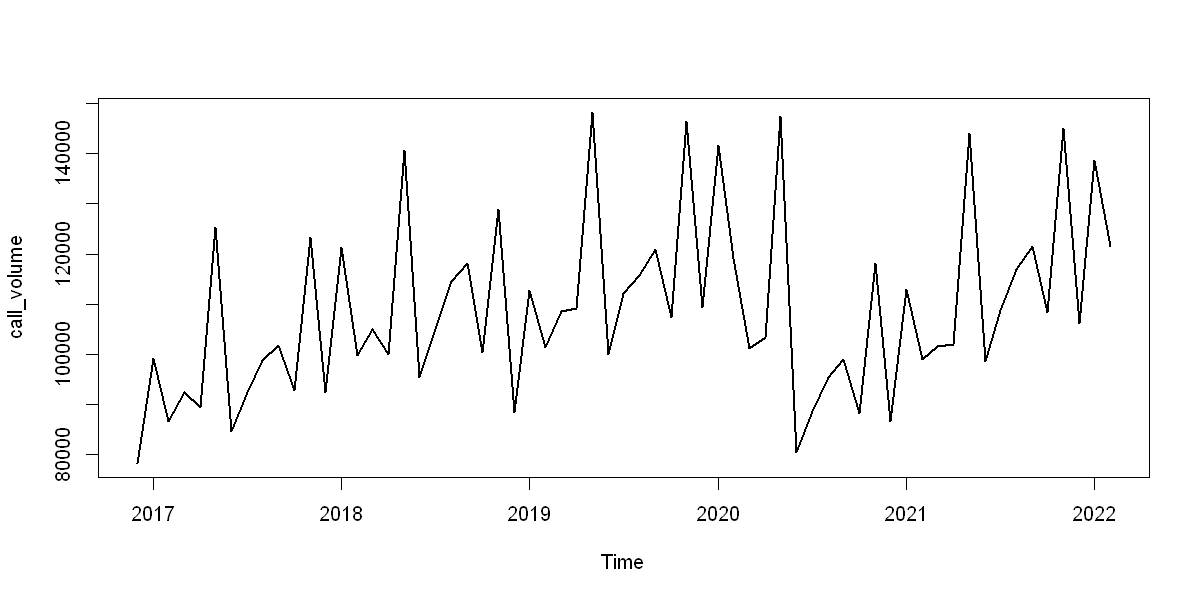

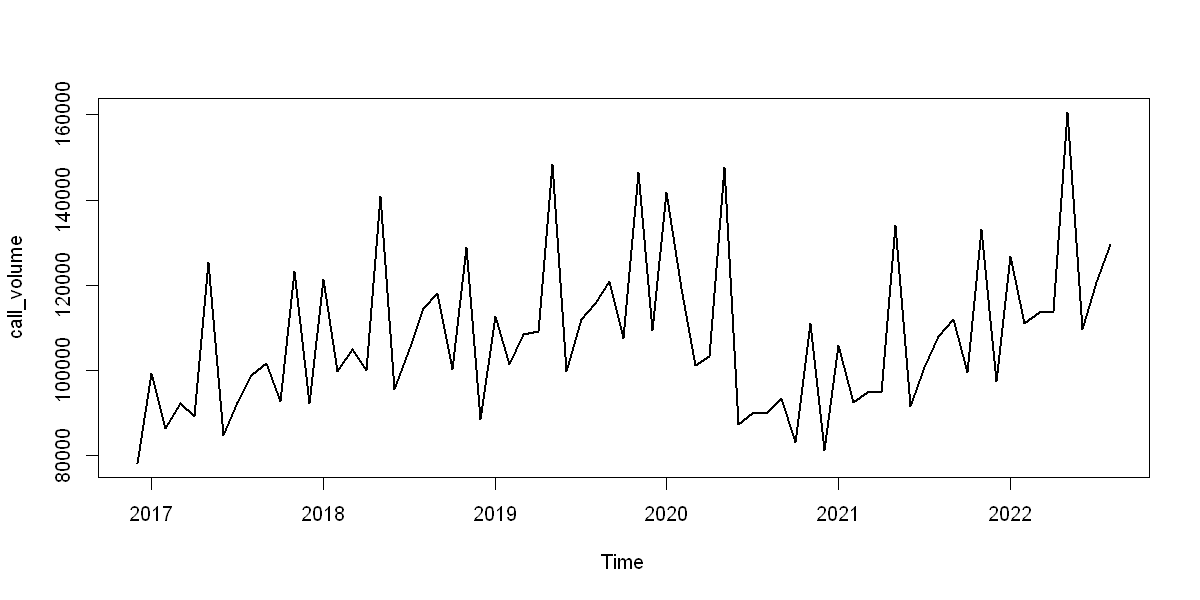

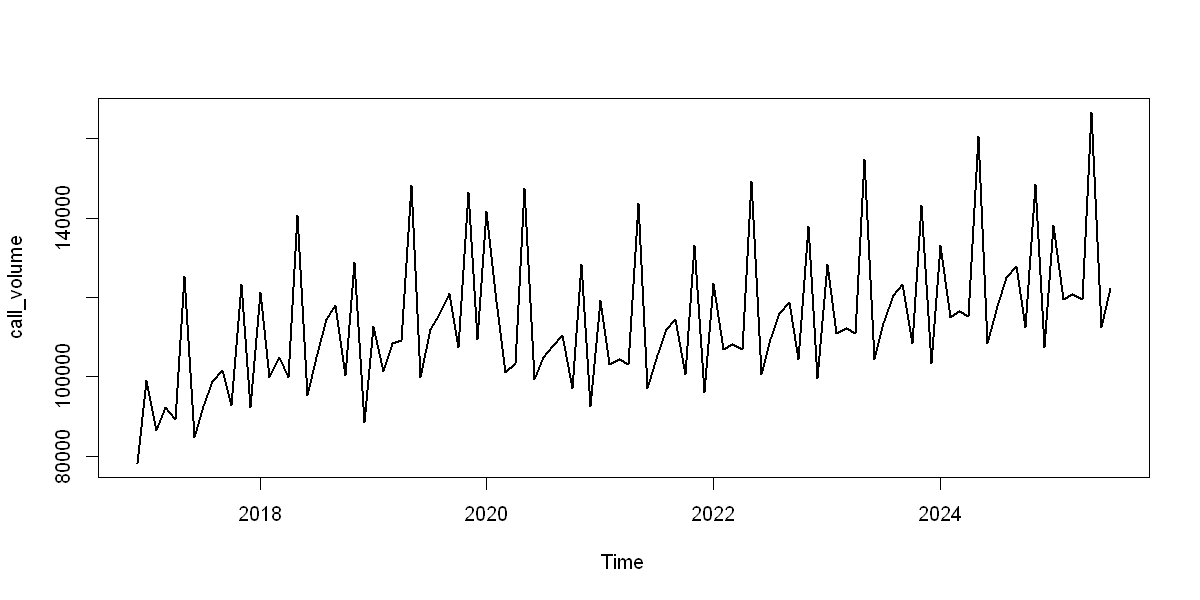

In [11]:
options(repr.plot.width=10, repr.plot.height=5)
for (i in sample(1:nrow(scenarios), size=4, replace=FALSE)) {
    temp0 <- recovery_forecast(scenario=scenarios[i,], model=fit_ets)
    temp0 <- temp0[,c('date','fit')]
    temp0$fit <- expm1(temp0$fit)
    startYear <- as.numeric(format(min(temp0$date), '%Y'))
    startMonth <- as.numeric(format(min(temp0$date), '%m'))
    plot(ts(temp0$fit, frequency = 12, start=c(startYear, startMonth)), lwd=2, lty=1, col='black', ylab='call_volume')
}

## (7) Forecasting call volume recovery

After generating 100 sets of forecasts from 100 different scenarios, there would be 100 forecasts per each point in time. The most likely of these forecasts is the median of forecasts per each point in time. The blue line below represents the median of forecasts per each point in the future. For historical points in time, the blue line represents the fitted value. The values plotted on the blue line (i.e. median of forecasts) can then be used for planning work force.

The thinner dashed blue lines are the 75-percent forecasts interval, i.e. 75% of the forecasts from 100 scenarios were between the thinner dashed blue lines. The 75-percent forecasts intervals can be used to manage risks for planning work force.

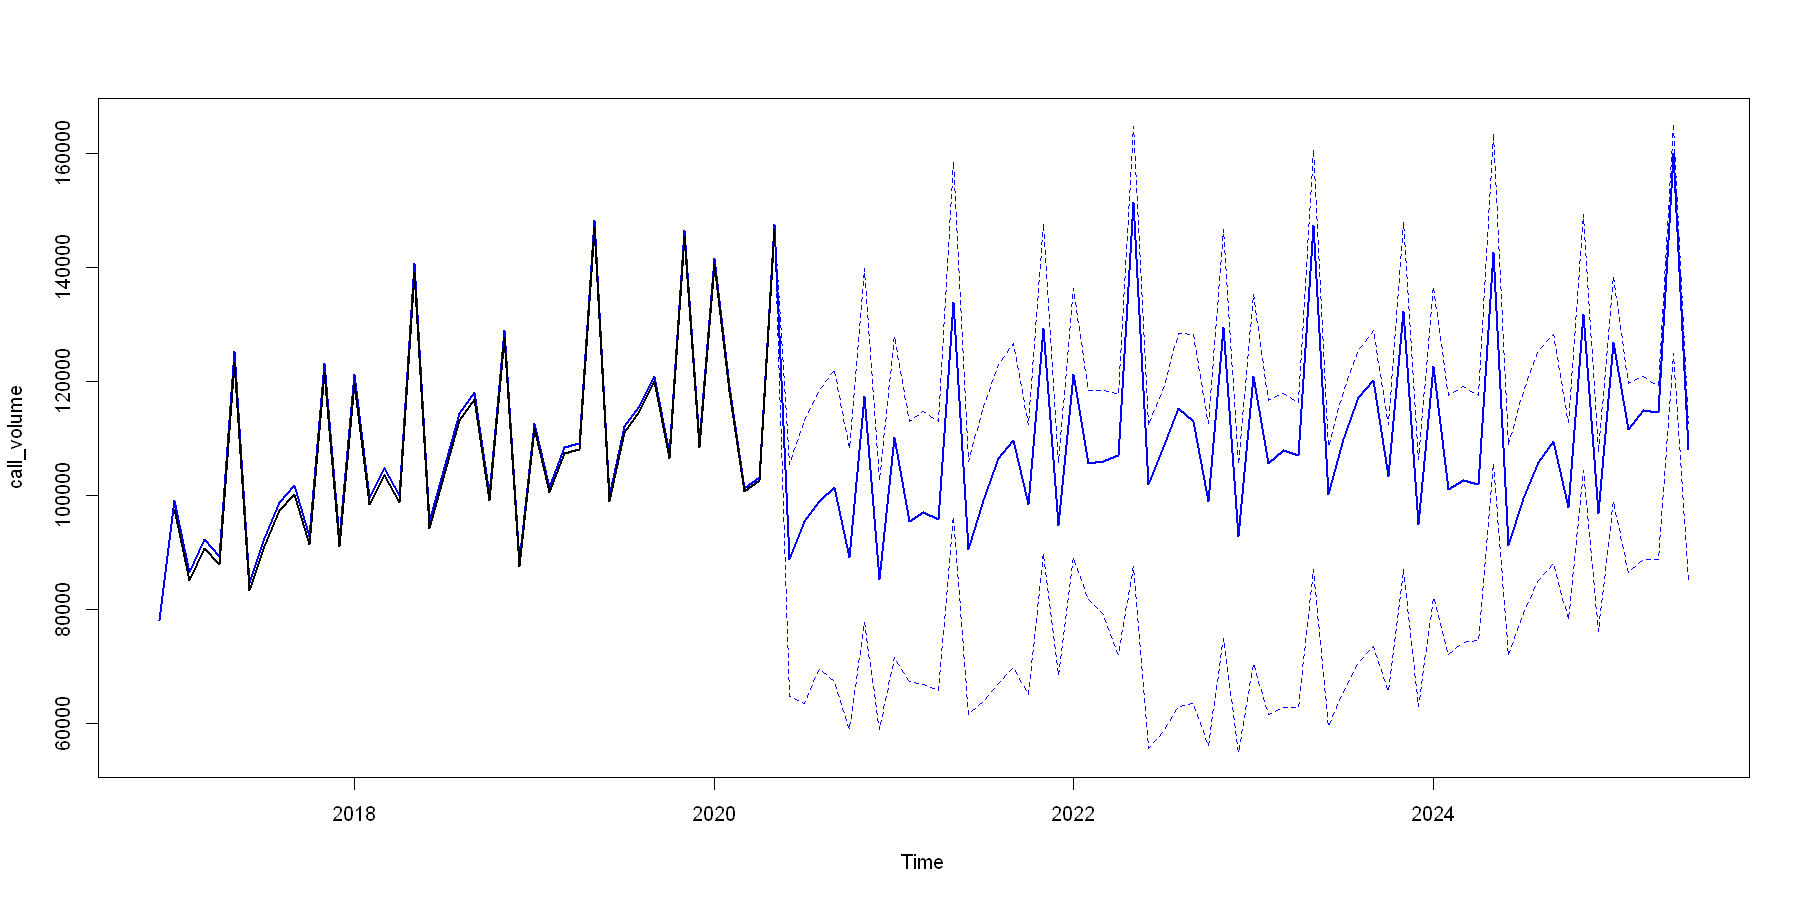

In [12]:
call_volume_df <- data.frame(date=as.Date(call_volume), volume=as.numeric(call_volume))
for (i in 1:nrow(scenarios)) {
    temp0 <- recovery_forecast(scenario=scenarios[i,], model=fit_ets)
    temp0 <- temp0[,c('date','fit')]
    temp0$fit <- expm1(temp0$fit)
    colName <- paste('fit',formatC(i, width = 3, format = "d", flag = "0"), sep='_') 
    colnames(temp0)[colnames(temp0) == 'fit'] <- colName
    call_volume_df <- merge(call_volume_df, temp0, by='date', all=TRUE)
}
colNames <- colnames(call_volume_df)[grepl(pattern='fit', colnames(call_volume_df))]

custom_quantile <- function(x, prob, na.rm) {
    if (length(x[!is.na(x)]) >= 15) {
        quantile(x=x,probs=prob,na.rm=na.rm)
    } else return(NA)
}
call_volume_df$fit_ll     <- apply(X=call_volume_df[,colNames], MARGIN=1, FUN=custom_quantile, prob=0.15, na.rm=TRUE)
call_volume_df$fit_median <- apply(X=call_volume_df[,colNames], MARGIN=1, FUN=custom_quantile, prob=0.50, na.rm=TRUE)
call_volume_df$fit_ul     <- apply(X=call_volume_df[,colNames], MARGIN=1, FUN=custom_quantile, prob=0.85, na.rm=TRUE)
call_volume_df <- call_volume_df[complete.cases(call_volume_df[,c('fit_ll','fit_median','fit_ul')]),]

startDate  <- min(call_volume_df$date)
startYear  <- as.numeric(format(startDate, '%Y'))
startMonth <- as.numeric(format(startDate, '%m'))

actuals <- ts(call_volume_df$volume,     frequency=12, start=c(startYear, startMonth))
fits    <- ts(call_volume_df$fit_median, frequency=12, start=c(startYear, startMonth))
llimits <- ts(call_volume_df$fit_ll,     frequency=12, start=c(startYear, startMonth))
ulimits <- ts(call_volume_df$fit_ul,     frequency=12, start=c(startYear, startMonth))

endDate <- max(call_volume_df$date)
endYear <- as.numeric(format(endDate, '%Y'))
endMonth <- as.numeric(format(endDate, '%m'))

xlim <- c(startYear + (startMonth - 1)/12, endYear + (endMonth - 1)/12) 
ylim <- c(min(c(actuals,fits,llimits,ulimits), na.rm=TRUE), max(c(actuals,fits,llimits,ulimits), na.rm=TRUE))

options(repr.plot.width=15, repr.plot.height=7.5)
plot(fits, lwd=2, lty=1, col='blue', xlim=xlim, ylim=ylim, ylab='call_volume')
lines(ulimits, lwd=1, lty=2, col='blue')
lines(llimits, lwd=1, lty=2, col='blue')
lines(actuals, lwd=2, lty=1, col='black')